## Inits

In [1]:
!pip install pykan

In [91]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda")
print(device)

cuda


## Dataset

In [97]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False)

    train_inputs = torch.empty(0, 8, device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, 8, device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)

    # Concatenate all data into a single tensor on the specified device
    for data, labels in tqdm(train_loader):
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in tqdm(test_loader):
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)

    dataset = {}
    dataset['train_input'] = train_inputs
    dataset['test_input'] = test_inputs
    dataset['train_label'] = train_labels.reshape(-1, 1)
    dataset['test_label'] = test_labels.reshape(-1, 1)

    return dataset

calhous_dataset = load_calhous_dataset()

100%|██████████| 4128/4128 [00:00<00:00, 5876.02it/s]


In [98]:
print("Train data shape: {}".format(calhous_dataset['train_input'].shape))
print("Train target shape: {}".format(calhous_dataset['train_label'].shape))
print("Test data shape: {}".format(calhous_dataset['test_input'].shape))
print("Test target shape: {}".format(calhous_dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([16512, 8])
Train target shape: torch.Size([16512, 1])
Test data shape: torch.Size([4128, 8])
Test target shape: torch.Size([4128, 1])


## Model

In [99]:
image_folder = 'video_img'

In [129]:
model = KAN(width=[8, 3, 1], grid=10, k=3, seed=0, device=device)

In [130]:
def train_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(calhous_dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, calhous_dataset['test_label'])
    return mse

results = model.train(calhous_dataset, opt="LBFGS", device=device, metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=25, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 5.34e-01 | test loss: 5.45e-01 | reg: 6.20e+00 : 100%|██| 25/25 [02:09<00:00,  5.19s/it]


In [131]:
print(results['train_mse'][-1], results['test_mse'][-1])

0.28563401103019714 0.2965337634086609


In [132]:
import moviepy.video.io.ImageSequenceClip

video_name='video'
fps=10

fps = fps
files = os.listdir(image_folder)
train_index = []
for file in files:
    if file[0].isdigit() and file.endswith('.jpg'):
        train_index.append(int(file[:-4]))

train_index = np.sort(train_index)

image_files = [image_folder+'/'+str(train_index[index])+'.jpg' for index in train_index]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
clip.write_videofile(video_name+'.mp4')

Moviepy - Building video video.mp4.
Moviepy - Writing video video.mp4



Moviepy - Done !
Moviepy - video ready video.mp4


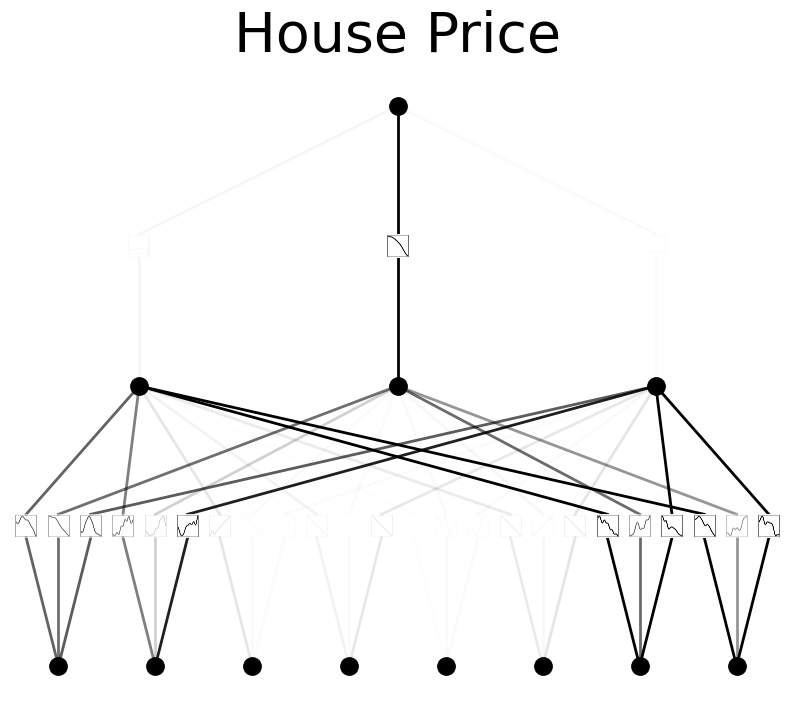

In [133]:
model.plot(beta=50, scale=1, out_vars=['House Price'])

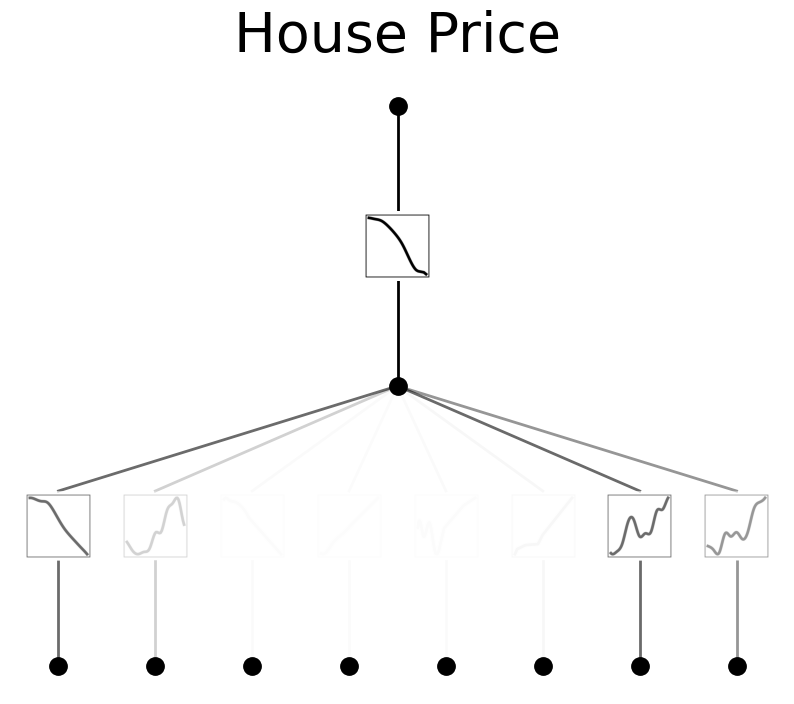

In [135]:
model = model.prune()
model(calhous_dataset['train_input'])
model.plot(beta=50, scale=1, out_vars=['House Price'])

# Neural Net

In [141]:
class CalHousNet(nn.Module):
    def __init__(self):
        super(CalHousNet, self).__init__()
        self.fc1 = nn.Linear(8, 3)  # 8 inputs to 5 hidden nodes
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(3, 1)  # 5 hidden nodes to 3 outputs

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = torch.nn.functional.mse_loss(outputs, labels, reduction='sum')
            total_loss += loss.item()
            total_count += labels.size(0)

    # Calculate the average MSE over all batches
    average_mse = total_loss / total_count
    print(f'Mean Squared Error: {average_mse}')

In [137]:
def load_calhous_dataset():
    # Load California housing dataset
    calhous = fetch_california_housing()
    data = calhous.data
    target = calhous.target

    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert to PyTorch tensors
    data_tensor = torch.tensor(data, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1, 1)

    # Split dataset into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(data_tensor, target_tensor, test_size=0.2, random_state=42)

    # Create data loaders (optional, if you want to batch and shuffle the data)
    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_target), batch_size=10, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_target), batch_size=10, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_calhous_dataset()

In [138]:
dataiter = iter(train_loader)
data, labels = next(dataiter)
print("Train data shape: {}".format(data.shape))
print("Train target shape: {}".format(labels.shape))
dataiter = iter(test_loader)
data, labels = next(dataiter)
print("Test data shape: {}".format(data.shape))
print("Test target shape: {}".format(labels.shape))
print("====================================")

Train data shape: torch.Size([10, 8])
Train target shape: torch.Size([10, 1])
Test data shape: torch.Size([10, 8])
Test target shape: torch.Size([10, 1])


In [142]:
model = CalHousNet().to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

train_model(model, train_loader, criterion, optimizer)

Epoch 1, Loss: 17.163938522338867
Epoch 2, Loss: 2.7833123207092285
Epoch 3, Loss: 2.514235496520996
Epoch 4, Loss: 0.3191354274749756
Epoch 5, Loss: 0.4191508889198303
Epoch 6, Loss: 2.878664016723633
Epoch 7, Loss: 0.9283462762832642
Epoch 8, Loss: 0.6055721640586853
Epoch 9, Loss: 0.7902647852897644
Epoch 10, Loss: 0.2652203440666199
Epoch 11, Loss: 0.7017927169799805
Epoch 12, Loss: 0.24795377254486084
Epoch 13, Loss: 0.05456564947962761
Epoch 14, Loss: 0.0028622429817914963
Epoch 15, Loss: 0.28283584117889404
Epoch 16, Loss: 0.7348670363426208
Epoch 17, Loss: 0.06438203901052475
Epoch 18, Loss: 0.34501945972442627
Epoch 19, Loss: 1.5411614179611206
Epoch 20, Loss: 0.7128186821937561
Epoch 21, Loss: 0.22028857469558716
Epoch 22, Loss: 0.4639418125152588
Epoch 23, Loss: 0.8142921328544617
Epoch 24, Loss: 0.013107018545269966
Epoch 25, Loss: 0.08482187986373901


In [140]:
test_model(model, test_loader)

Mean Squared Error: 0.41091049998969764
